## EXPLORE AND VISUALIZE Game Data for Michigan State and Future Opponents


In [1]:
# Depencies

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




# Connect to the SQLite database
db_path = '2023 Game Stats_Scraped_10_22_23.db'  # Replace with your actual database path
conn = sqlite3.connect(db_path)

################### SET THE HIGHLIGHTED TEAMS ####################
# Highlight Michigan State and Boston College
highlight_teams_shots = ['MSU', 'BC']
highlight_colors_shots = {'MSU': 'darkgreen', 'BC': 'maroon'}
highlight_colors = {'MSU': 'darkgreen', 'BC': 'maroon'}

## List the tables in the database
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
print(tables)



                     name
0            game_details
1         scoring_summary
2         penalty_summary
3            goalie_stats
4            player_stats
5              line_chart
6               linescore
7  advanced_metrics_team1
8  advanced_metrics_team2


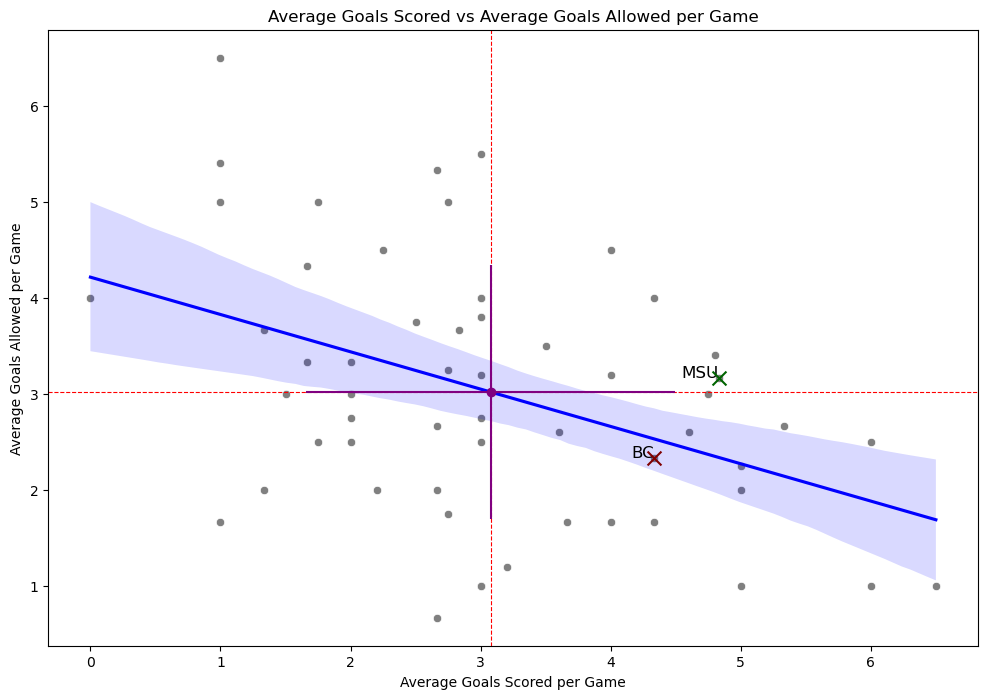

In [2]:

# Query to get the average goals scored and allowed per game for each team
avg_goals_query = """
SELECT
    a.Team,
    AVG(a.goalsT) AS Avg_Goals_Scored,
    AVG(b.goalsT) AS Avg_Goals_Allowed
FROM linescore AS a
JOIN linescore AS b ON a.Game_ID = b.Game_ID AND a.Team != b.Team
GROUP BY a.Team;
"""

# Execute the query and store the results in a DataFrame
avg_goals_df = pd.read_sql(avg_goals_query, conn)

# Calculate average and standard deviation for "Goals Scored" and "Goals Allowed"
avg_goals_scored = avg_goals_df['Avg_Goals_Scored'].mean()
std_goals_scored = avg_goals_df['Avg_Goals_Scored'].std()
avg_goals_allowed = avg_goals_df['Avg_Goals_Allowed'].mean()
std_goals_allowed = avg_goals_df['Avg_Goals_Allowed'].std()

# Create the scatter plot with trend line, average, and standard deviation
plt.figure(figsize=(12, 8))

# Scatter plot
sns.scatterplot(data=avg_goals_df, x='Avg_Goals_Scored', y='Avg_Goals_Allowed', color='grey')

# Add trend line
sns.regplot(data=avg_goals_df, x='Avg_Goals_Scored', y='Avg_Goals_Allowed', scatter=False, color='blue')

# Add average lines
plt.axvline(x=avg_goals_scored, color='red', linestyle='--', linewidth=0.8)
plt.axhline(y=avg_goals_allowed, color='red', linestyle='--', linewidth=0.8)

# Add standard deviation lines
plt.errorbar(avg_goals_scored, avg_goals_allowed, xerr=std_goals_scored, yerr=std_goals_allowed, color='purple', fmt='o')


for team, color in highlight_colors.items():
    team_data = avg_goals_df[avg_goals_df['Team'] == team]
    plt.scatter(team_data['Avg_Goals_Scored'], team_data['Avg_Goals_Allowed'], color=color, s=100, zorder=5, marker = 'x')
    plt.text(team_data['Avg_Goals_Scored'].values[0], team_data['Avg_Goals_Allowed'].values[0], team, fontsize=12, ha='right')

plt.title('Average Goals Scored vs Average Goals Allowed per Game')
plt.xlabel('Average Goals Scored per Game')
plt.ylabel('Average Goals Allowed per Game')
plt.show()

## Average Shots Per Game (for and Against)



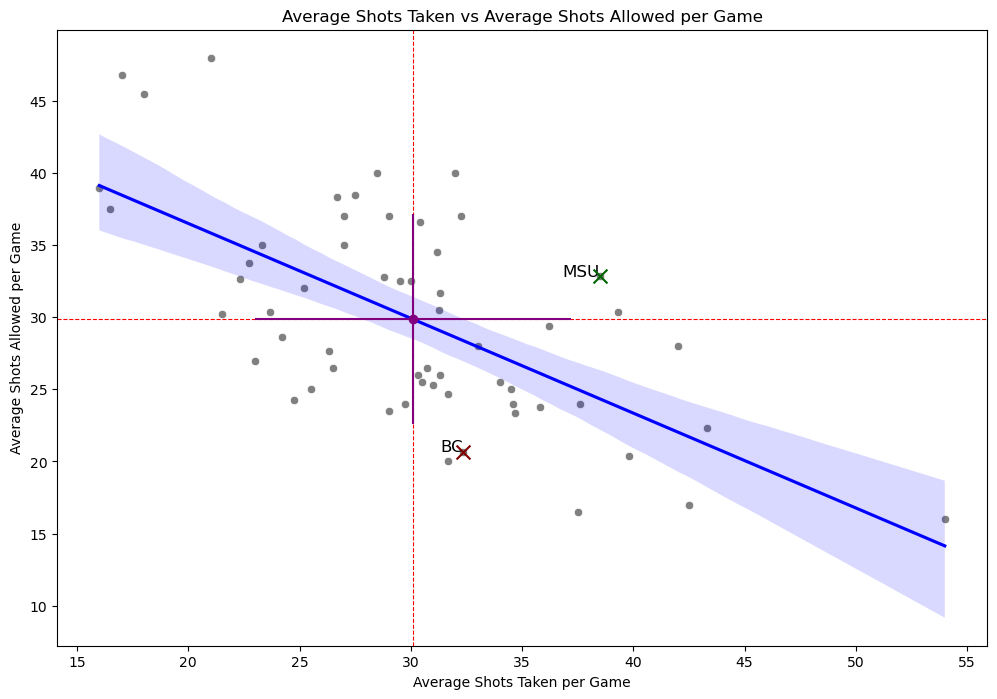

In [3]:
# Query to get the average shots taken and allowed per game for each team using the previous database connection
avg_shots_query = """
SELECT
    a.Team,
    AVG(a.shotsT) AS Avg_Shots_Taken,
    AVG(b.shotsT) AS Avg_Shots_Allowed
FROM linescore AS a
JOIN linescore AS b ON a.Game_ID = b.Game_ID AND a.Team != b.Team
GROUP BY a.Team;
"""

# Execute the query and store the results in a DataFrame
avg_shots_df = pd.read_sql(avg_shots_query, conn)

# Calculate average and standard deviation for "Shots Taken" and "Shots Allowed"
avg_shots_taken = avg_shots_df['Avg_Shots_Taken'].mean()
std_shots_taken = avg_shots_df['Avg_Shots_Taken'].std()
avg_shots_allowed = avg_shots_df['Avg_Shots_Allowed'].mean()
std_shots_allowed = avg_shots_df['Avg_Shots_Allowed'].std()



# Create the scatter plot for average shots taken and allowed
plt.figure(figsize=(12, 8))
sns.scatterplot(data=avg_shots_df, x='Avg_Shots_Taken', y='Avg_Shots_Allowed', color='grey')


# Add trend line
sns.regplot(data=avg_shots_df, x='Avg_Shots_Taken', y='Avg_Shots_Allowed', scatter=False, color='blue')

# Add average lines
plt.axvline(x=avg_shots_taken, color='red', linestyle='--', linewidth=0.8)
plt.axhline(y=avg_shots_allowed, color='red', linestyle='--', linewidth=0.8)

# Add standard deviation lines
plt.errorbar(avg_shots_taken, avg_shots_allowed, xerr=std_shots_taken, yerr=std_shots_allowed, color='purple', fmt='o')


# Highlight Michigan State and Boston College
for team, color in highlight_colors_shots.items():
    team_data = avg_shots_df[avg_shots_df['Team'] == team]
    plt.scatter(team_data['Avg_Shots_Taken'], team_data['Avg_Shots_Allowed'], color=color, s=100, zorder=5, marker = 'x')
    plt.text(team_data['Avg_Shots_Taken'].values[0], team_data['Avg_Shots_Allowed'].values[0], team, fontsize=12, ha='right')

plt.title('Average Shots Taken vs Average Shots Allowed per Game')
plt.xlabel('Average Shots Taken per Game')
plt.ylabel('Average Shots Allowed per Game')
plt.show()




## Average penelty minutes per game

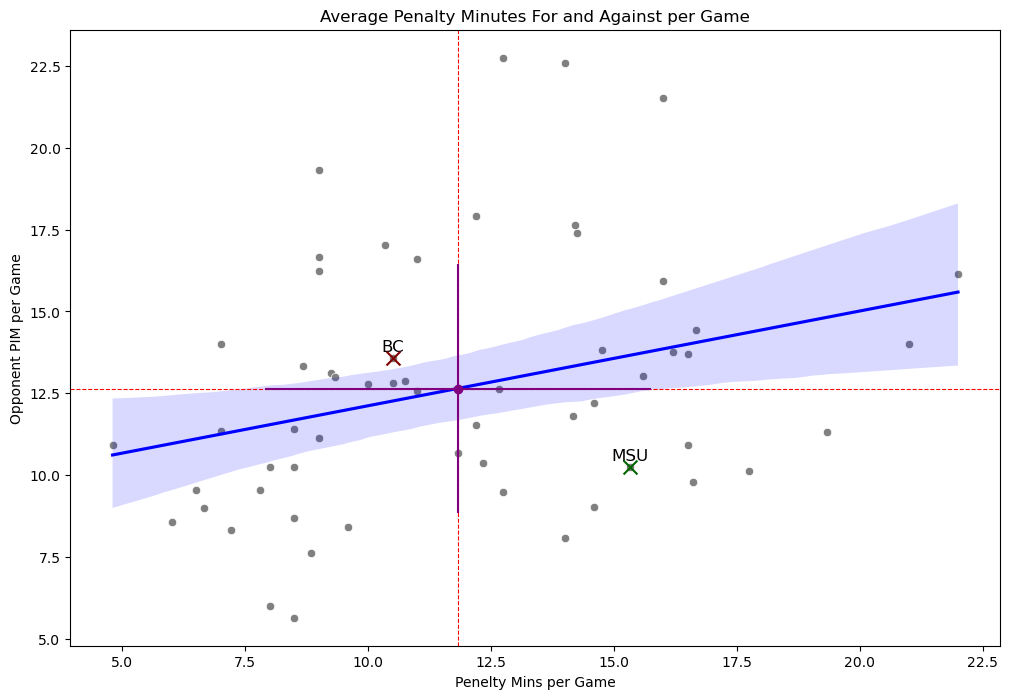

In [4]:
# SQL query to calculate the average penalty minutes "for" and "against" each team
avg_penalty_for_against_query = """
WITH PenaltyFor AS (
    SELECT
        Team,
        AVG(Total_Penalty_Minutes) AS Avg_Penalty_Minutes_For
    FROM (
        SELECT
            Team,
            Game_ID,
            SUM(Pen_Length) AS Total_Penalty_Minutes
        FROM penalty_summary
        GROUP BY Team, Game_ID
    )
    GROUP BY Team
),
PenaltyAgainst AS (
    SELECT
        b.Team,
        AVG(a.Total_Penalty_Minutes) AS Avg_Penalty_Minutes_Against
    FROM (
        SELECT
            Team,
            Game_ID,
            SUM(Pen_Length) AS Total_Penalty_Minutes
        FROM penalty_summary
        GROUP BY Team, Game_ID
    ) AS a
    JOIN penalty_summary AS b ON a.Game_ID = b.Game_ID AND a.Team != b.Team
    GROUP BY b.Team
)
SELECT
    a.Team,
    a.Avg_Penalty_Minutes_For,
    b.Avg_Penalty_Minutes_Against
FROM PenaltyFor AS a
JOIN PenaltyAgainst AS b ON a.Team = b.Team;
"""

# Execute the query and store the results in a DataFrame
avg_penalty_for_against_df = pd.read_sql(avg_penalty_for_against_query, conn)
# avg_penalty_for_against_df.head()

# Calculate average and standard deviation for "For" and "Against"
avg_for = avg_penalty_for_against_df['Avg_Penalty_Minutes_For'].mean()
std_for = avg_penalty_for_against_df['Avg_Penalty_Minutes_For'].std()
avg_against = avg_penalty_for_against_df['Avg_Penalty_Minutes_Against'].mean()
std_against = avg_penalty_for_against_df['Avg_Penalty_Minutes_Against'].std()


# Create the scatter plot with trend line, average, and standard deviation
plt.figure(figsize=(12, 8))

# Scatter plot
sns.scatterplot(data=avg_penalty_for_against_df, x='Avg_Penalty_Minutes_For', y='Avg_Penalty_Minutes_Against', color='grey')

# Add trend line
sns.regplot(data=avg_penalty_for_against_df, x='Avg_Penalty_Minutes_For', y='Avg_Penalty_Minutes_Against', scatter=False, color='blue')

# Add average lines
plt.axvline(x=avg_for, color='red', linestyle='--', linewidth=0.8)
plt.axhline(y=avg_against, color='red', linestyle='--', linewidth=0.8)

# Add standard deviation lines
plt.errorbar(avg_for, avg_against, xerr=std_for, yerr=std_against, color='purple', fmt='o')


# Highlight Michigan State and Boston College
for team, color in highlight_colors_shots.items():
    team_data = avg_penalty_for_against_df[avg_penalty_for_against_df['Team'] == team]
    plt.scatter(team_data['Avg_Penalty_Minutes_For'], team_data['Avg_Penalty_Minutes_Against'], color=color, s=100, zorder=5, marker='x')
    plt.text(team_data['Avg_Penalty_Minutes_For'].values[0], team_data['Avg_Penalty_Minutes_Against'].values[0] + 0.2, team, fontsize=12, ha='center')

plt.title('Average Penalty Minutes For and Against per Game')
plt.xlabel('Penelty Mins per Game')
plt.ylabel('Opponent PIM per Game')
plt.show()




# Goals Scored by Time of Game

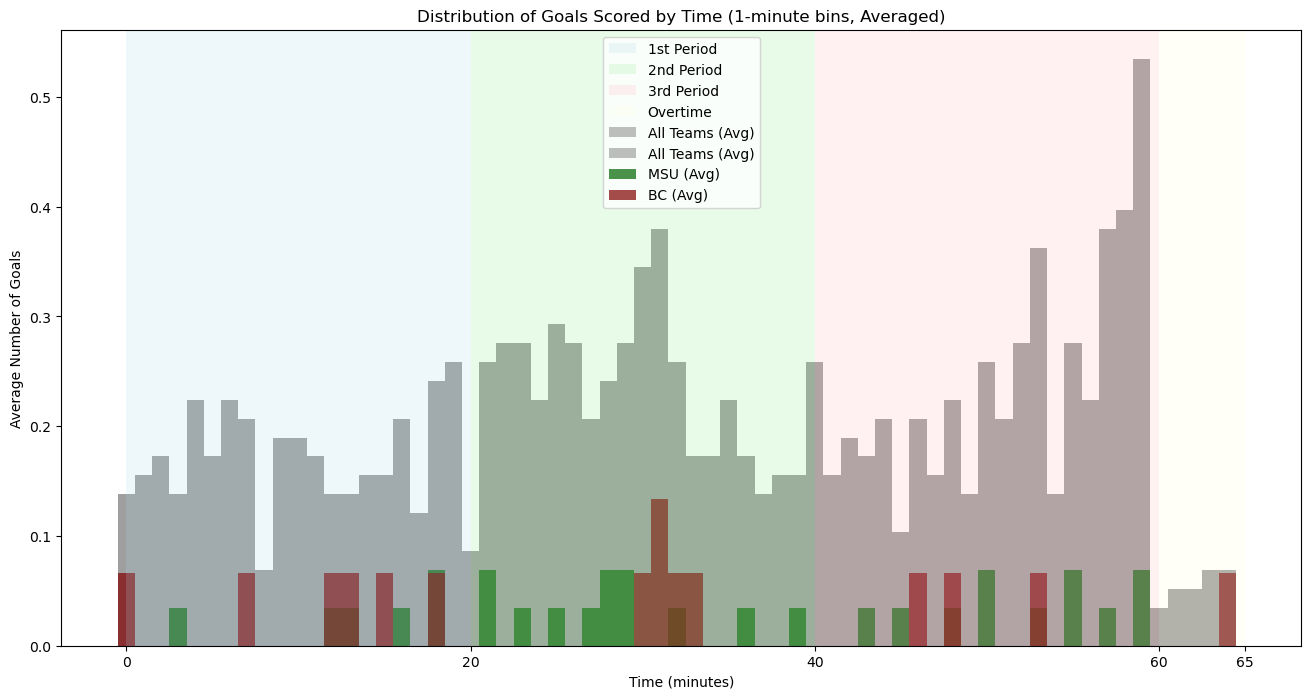

In [5]:
import matplotlib.ticker as ticker

# Query to get the time and period of goals scored by each team
goals_time_query = """
SELECT Team, Period, Time
FROM scoring_summary;
"""

# Execute the query and store the results in a DataFrame
goals_time_df = pd.read_sql(goals_time_query, conn)

# Convert Period and Time to a single continuous time in minutes
def convert_to_continuous_time(row):
    period = row['Period']
    time = row['Time']
    
    # Convert the period time to minutes and seconds
    minutes, seconds = map(int, time.split(':'))
    
    # Add the period offset to the time
    if period == '1st Period':
        offset = 0
    elif period == '2nd Period':
        offset = 20
    elif period == '3rd Period':
        offset = 40
    else:  # Overtime periods
        offset = 60
        
    return offset + minutes + seconds / 60.0

goals_time_df['Continuous_Time'] = goals_time_df.apply(convert_to_continuous_time, axis=1)

# Create the histogram with improved visibility and period zones
plt.figure(figsize=(16, 8))


# Plot the average goals by all teams in each 1-minute bin
all_teams_data = goals_time_df['Continuous_Time']
bin_counts, bin_edges = np.histogram(all_teams_data, bins=range(0, 66))
bin_avgs = bin_counts / len(np.unique(goals_time_df['Team']))
plt.bar(bin_edges[:-1], bin_avgs, width=1, alpha=0.5, label='All Teams (Avg)', color='grey')


# Plot the average goals by all teams in each 1-minute bin
bin_avgs_all_teams = bin_counts / len(np.unique(goals_time_df['Team']))
plt.bar(bin_edges[:-1], bin_avgs_all_teams, width=1, alpha=0.5, label='All Teams (Avg)', color='grey')

# Plot average goals by MSU and BC in 1-minute bins
for team, color in highlight_colors_shots.items():
    team_data = goals_time_df[goals_time_df['Team'] == team]['Continuous_Time']
    team_bin_counts, _ = np.histogram(team_data, bins=range(0, 66))
    team_bin_avgs = team_bin_counts / len(team_data)  # Normalize by the number of goals by the team
    plt.bar(bin_edges[:-1], team_bin_avgs, width=1, alpha=0.7, label=f"{team} (Avg)", color=color)

# Add period zones
plt.axvspan(0, 20, facecolor='lightblue', alpha=0.2, label='1st Period')
plt.axvspan(20, 40, facecolor='lightgreen', alpha=0.2, label='2nd Period')
plt.axvspan(40, 60, facecolor='lightpink', alpha=0.2, label='3rd Period')
plt.axvspan(60, 65, facecolor='lightyellow', alpha=0.2, label='Overtime')

plt.title('Distribution of Goals Scored by Time (1-minute bins, Averaged)')
plt.xlabel('Time (minutes)')
plt.ylabel('Average Number of Goals')
plt.legend()

# Customize x-axis with period zones
plt.xticks([0, 20, 40, 60, 65], ['Start', '1st-2nd Intermission', '2nd-3rd Intermission', 'End of Regulation', 'End of Overtime'])
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.show()


## Create Top Five Reports for MSU and Opponent (Goals, shots, assists, PIMs, blocked shots)

In [6]:
# Adjust query to get player stats for each team in the categories of interest
# Note: Ignoring the player's number as per user's request
adjusted_player_stats_query = """
SELECT
    Team,
    Player,
    SUM(G) AS Total_Goals,
    SUM(Sh) AS Total_Shots,
    SUM(A) AS Total_Assists,
    SUM(PIM) AS Total_Penalty_Minutes
FROM player_stats
GROUP BY Team, Player
ORDER BY Team, Total_Goals DESC, Total_Shots DESC, Total_Assists DESC, Total_Penalty_Minutes DESC;
"""

# Execute the query and store the results in a DataFrame
adjusted_player_stats_df = pd.read_sql(adjusted_player_stats_query, conn)

#############################################################################
# FILTER THE DATAFRAME FOR THE TEAMS OF INTEREST
#############################################################################
# Filter the DataFrame to include only the stats for MSU and BC
msu_stats = adjusted_player_stats_df[adjusted_player_stats_df['Team'] == 'Michigan State']
bc_stats = adjusted_player_stats_df[adjusted_player_stats_df['Team'] == 'Boston College']

# Display the top players for each team in each category
def display_top_players(team_stats, team_name, categories):
    print(f"Top Players for {team_name}")
    for category in categories:
        print(f"\nTop Players in {category}:")
        display(team_stats.nlargest(5, category)[['Player', category]])

# Categories to display
categories = ['Total_Goals', 'Total_Shots', 'Total_Assists', 'Total_Penalty_Minutes']

# Display the tables for MSU and BC
display_top_players(msu_stats, 'Michigan State (MSU)', categories)
print("\n" + "="*50 + "\n")
display_top_players(bc_stats, 'Boston College (BC)', categories)


Top Players for Michigan State (MSU)

Top Players in Total_Goals:


,Player,Total_Goals
755,Daniel Russell,5.0
756,Joey Larson,4.0
757,Artyom Levshunov,3.0
758,Reed Lebster,3.0
759,Red Savage,3.0



Top Players in Total_Shots:


,Player,Total_Shots
756,Joey Larson,27.0
757,Artyom Levshunov,21.0
764,Isaac Howard,21.0
760,Karsen Dorwart,20.0
761,Nicolas Muller,18.0



Top Players in Total_Assists:


,Player,Total_Assists
761,Nicolas Muller,7.0
759,Red Savage,6.0
764,Isaac Howard,5.0
756,Joey Larson,4.0
760,Karsen Dorwart,4.0



Top Players in Total_Penalty_Minutes:


,Player,Total_Penalty_Minutes
773,David Gucciardi,19.0
774,Owen Baker,15.0
771,Tiernan Shoudy,10.0
772,Jeremy Davidson,8.0
759,Red Savage,6.0




Top Players for Boston College (BC)

Top Players in Total_Goals:


,Player,Total_Goals
239,Cutter Gauthier,3.0
240,Will Smith,3.0
241,Oskar Jellvik,3.0
242,Andre Gasseau,2.0
243,Gabe Perreault,1.0



Top Players in Total_Shots:


,Player,Total_Shots
239,Cutter Gauthier,26.0
247,Ryan Leonard,15.0
240,Will Smith,9.0
241,Oskar Jellvik,9.0
242,Andre Gasseau,8.0



Top Players in Total_Assists:


,Player,Total_Assists
247,Ryan Leonard,3.0
240,Will Smith,2.0
242,Andre Gasseau,2.0
248,Colby Ambrosio,2.0
249,Eamon Powell,2.0



Top Players in Total_Penalty_Minutes:


,Player,Total_Penalty_Minutes
240,Will Smith,4.0
243,Gabe Perreault,4.0
245,Jack Malone,4.0
249,Eamon Powell,4.0
256,Aram Minnetian,4.0


### Blocked Shots Tables for MSU and BC

In [7]:
# Query to get player stats for blocked shots, accounting for the team information in Game_ID
blocked_shots_query = """
WITH Team_Info AS (
    SELECT
        CASE 
            WHEN Game_ID LIKE '%Michigan State-%' THEN 'Michigan State'
            WHEN Game_ID LIKE '%-Michigan State' THEN 'Michigan State'
            WHEN Game_ID LIKE '%Boston College-%' THEN 'Boston College'
            WHEN Game_ID LIKE '%-Boston College' THEN 'Boston College'
        END AS Team,
        Game_ID,
        Player,
        TOTAL_Block AS Total_Shots_Blocked,
        D_Blocks AS Total_Defensive_Blocks
    FROM (
        SELECT * FROM advanced_metrics_team1
        UNION ALL
        SELECT * FROM advanced_metrics_team2
    )
    WHERE Game_ID LIKE '%Michigan State%' OR Game_ID LIKE '%Boston College%'
)
SELECT
    Team,
    Player,
    SUM(Total_Shots_Blocked) AS Total_Shots_Blocked,
    SUM(Total_Defensive_Blocks) AS Total_Defensive_Blocks
FROM Team_Info
GROUP BY Team, Player
ORDER BY Team, Total_Shots_Blocked DESC, Total_Defensive_Blocks DESC;
"""

# Execute the query and store the results in a DataFrame
blocked_shots_df = pd.read_sql(blocked_shots_query, conn)

# Filter the DataFrame to include only the stats for Michigan State and Boston College
msu_blocked_shots_stats = blocked_shots_df[blocked_shots_df['Team'] == 'Michigan State']
bc_blocked_shots_stats = blocked_shots_df[blocked_shots_df['Team'] == 'Boston College']

# Categories for blocked shots
blocked_shots_categories = ['Total_Shots_Blocked', 'Total_Defensive_Blocks']

# Display the tables for MSU and BC for blocked shots
display_top_players(msu_blocked_shots_stats, 'Michigan State', blocked_shots_categories)
print("\n" + "="*50 + "\n")
display_top_players(bc_blocked_shots_stats, 'Boston College', blocked_shots_categories)


Top Players for Michigan State

Top Players in Total_Shots_Blocked:


,Player,Total_Shots_Blocked
58,TOTAL,162.0
59,Artyom Levshunov,18.0
60,Joey Larson,16.0
61,Isaac Howard,14.0
62,Daniel Russell,10.0



Top Players in Total_Defensive_Blocks:


,Player,Total_Defensive_Blocks
58,TOTAL,142.0
78,Powell Connor,10.0
79,Jordan Venegoni,8.0
59,Artyom Levshunov,6.0
63,Red Savage,6.0




Top Players for Boston College

Top Players in Total_Shots_Blocked:


,Player,Total_Shots_Blocked
0,TOTAL,72.0
1,Sean Behrens,8.0
2,Shai Buium,6.0
3,Aidan Thompson,6.0
4,Massimo Rizzo,6.0



Top Players in Total_Defensive_Blocks:


,Player,Total_Defensive_Blocks
0,TOTAL,58.0
21,John Gormley,12.0
2,Shai Buium,6.0
1,Sean Behrens,4.0
11,Valtteri Piironen,4.0


## Breakdown Player Goals, Assists and Penelty Minutes by Line Assignment

In [8]:
# Query to get line-specific stats for goals, assists, and penalty minutes scored for each team,
# now also including the Position column to distinguish between Forwards and Defensemen
line_goals_assists_pim_position_query = """
SELECT
    lc.Team,
    lc.Line,
    lc.Position,
    SUM(ps.G) AS Total_Goals,
    SUM(ps.A) AS Total_Assists,
    SUM(ps.PIM) AS Total_PIM
FROM line_chart AS lc
LEFT JOIN player_stats AS ps ON lc.Game_ID = ps.Game_ID AND lc.Team = ps.Team AND lc.Player = ps.Player
WHERE lc.Position != 'Goalie'
GROUP BY lc.Team, lc.Line, lc.Position
ORDER BY lc.Team, lc.Line, lc.Position;
"""

# Execute the query and store the results in a DataFrame
line_goals_assists_pim_position_df = pd.read_sql(line_goals_assists_pim_position_query, conn)

# Create a new column 'Type' to distinguish between Forwards and Defensemen
line_goals_assists_pim_position_df['Type'] = line_goals_assists_pim_position_df['Position'].apply(lambda x: 'Forward' if x in ['Left Wing', 'Right Wing', 'Center'] else 'Defense')

# Preview the first few rows of the DataFrame to ensure the data looks as expected
# line_goals_assists_pim_position_df.head()


C:\Users\Justin\AppData\Local\Temp\ipykernel_19688\1203290277.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Line', y='Total_Goals', hue='Team', data=forwards_data,
C:\Users\Justin\AppData\Local\Temp\ipykernel_19688\1203290277.py:10: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey'` for the same effect.

  sns.barplot(x='Line', y='Total_Goals', hue='Team', data=forwards_data,
C:\Users\Justin\AppData\Local\Temp\ipykernel_19688\1203290277.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Line', y='Total_Goals', hue='Team', data=forwards_data[forwards_data['Team'].isin(['Michigan State', 'Boston College'])],
C:\Users\Justin\AppData\Local\Temp\ipykernel_19688\1203290277.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.bar

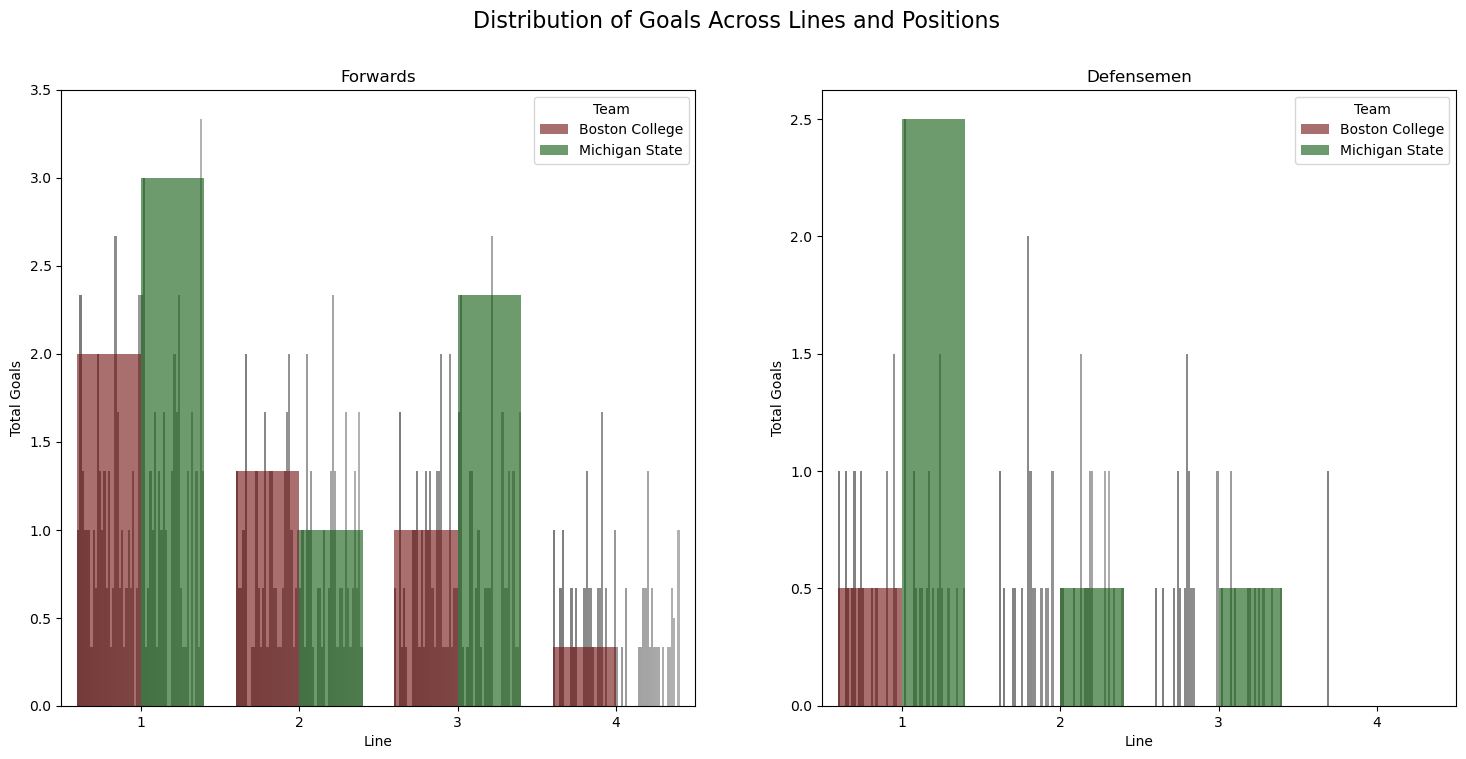

In [9]:
# Set up the plot
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Distribution of Goals Across Lines and Positions', fontsize=16)

# Filter data for Forwards and Defensemen
forwards_data = line_goals_assists_pim_position_df[line_goals_assists_pim_position_df['Type'] == 'Forward']
defense_data = line_goals_assists_pim_position_df[line_goals_assists_pim_position_df['Type'] == 'Defense']

# Plot data for Forwards
sns.barplot(x='Line', y='Total_Goals', hue='Team', data=forwards_data, 
            color='grey', alpha=0.6, ax=ax[0], ci=None)
sns.barplot(x='Line', y='Total_Goals', hue='Team', data=forwards_data[forwards_data['Team'].isin(['Michigan State', 'Boston College'])], 
            palette={'Michigan State': 'darkgreen', 'Boston College': 'maroon'}, ax=ax[0], ci=None, alpha=0.6)

# Plot data for Defensemen
sns.barplot(x='Line', y='Total_Goals', hue='Team', data=defense_data, 
            color='grey', alpha=0.6, ax=ax[1], ci=None)
sns.barplot(x='Line', y='Total_Goals', hue='Team', data=defense_data[defense_data['Team'].isin(['Michigan State', 'Boston College'])], 
            palette={'Michigan State': 'darkgreen', 'Boston College': 'maroon'}, ax=ax[1], ci=None, alpha=0.6)

# Add labels and title
ax[0].set_title('Forwards')
ax[1].set_title('Defensemen')
ax[0].set_xlabel('Line')
ax[1].set_xlabel('Line')
ax[0].set_ylabel('Total Goals')
ax[1].set_ylabel('Total Goals')

# Simplify the legend to only show Michigan State and Boston College
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[-2:], labels[-2:], title='Team')

handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[-2:], labels[-2:], title='Team')

# Show the plot
plt.show()


## Assists by Line Assignment

C:\Users\Justin\AppData\Local\Temp\ipykernel_19688\4107984458.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Line', y='Total_Assists', hue='Team', data=forwards_data,
C:\Users\Justin\AppData\Local\Temp\ipykernel_19688\4107984458.py:6: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey'` for the same effect.

  sns.barplot(x='Line', y='Total_Assists', hue='Team', data=forwards_data,
C:\Users\Justin\AppData\Local\Temp\ipykernel_19688\4107984458.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Line', y='Total_Assists', hue='Team', data=forwards_data[forwards_data['Team'].isin(['Michigan State', 'Boston College'])],
C:\Users\Justin\AppData\Local\Temp\ipykernel_19688\4107984458.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.

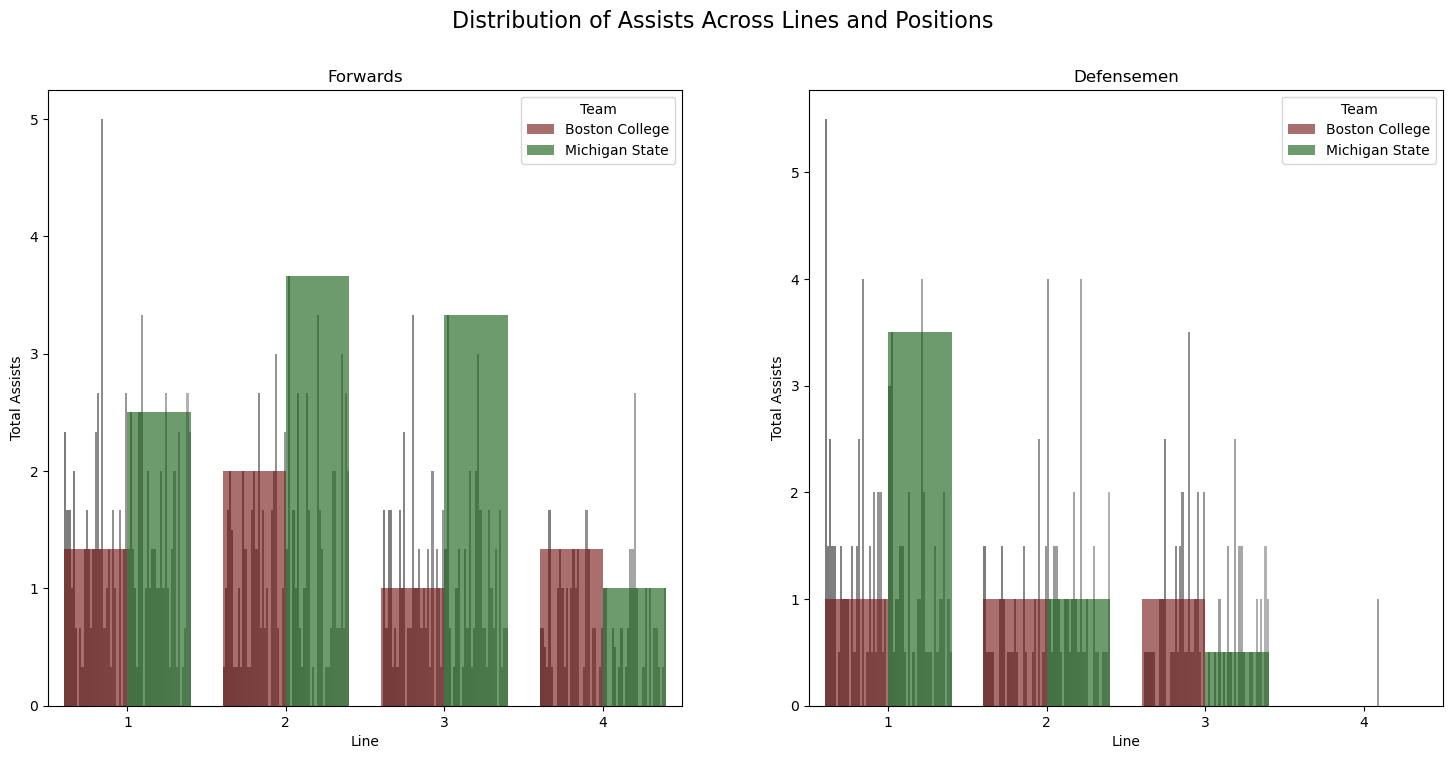

In [10]:
# Set up the plot for Assists
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Distribution of Assists Across Lines and Positions', fontsize=16)

# Plot data for Forwards
sns.barplot(x='Line', y='Total_Assists', hue='Team', data=forwards_data, 
            color='grey', alpha=0.6, ax=ax[0], ci=None)
sns.barplot(x='Line', y='Total_Assists', hue='Team', data=forwards_data[forwards_data['Team'].isin(['Michigan State', 'Boston College'])], 
            palette={'Michigan State': 'darkgreen', 'Boston College': 'maroon'}, ax=ax[0], ci=None, alpha=0.6)

# Plot data for Defensemen
sns.barplot(x='Line', y='Total_Assists', hue='Team', data=defense_data, 
            color='grey', alpha=0.6, ax=ax[1], ci=None)
sns.barplot(x='Line', y='Total_Assists', hue='Team', data=defense_data[defense_data['Team'].isin(['Michigan State', 'Boston College'])], 
            palette={'Michigan State': 'darkgreen', 'Boston College': 'maroon'}, ax=ax[1], ci=None, alpha=0.6)

# Add labels and title
ax[0].set_title('Forwards')
ax[1].set_title('Defensemen')
ax[0].set_xlabel('Line')
ax[1].set_xlabel('Line')
ax[0].set_ylabel('Total Assists')
ax[1].set_ylabel('Total Assists')

# Simplify the legend to only show Michigan State and Boston College
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[-2:], labels[-2:], title='Team')

handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[-2:], labels[-2:], title='Team')

# Show the plot
plt.show()


## Penety Minutes By Line Assignment

C:\Users\Justin\AppData\Local\Temp\ipykernel_19688\2880309655.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Line', y='Total_PIM', hue='Team', data=forwards_data,
C:\Users\Justin\AppData\Local\Temp\ipykernel_19688\2880309655.py:6: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey'` for the same effect.

  sns.barplot(x='Line', y='Total_PIM', hue='Team', data=forwards_data,
C:\Users\Justin\AppData\Local\Temp\ipykernel_19688\2880309655.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Line', y='Total_PIM', hue='Team', data=forwards_data[forwards_data['Team'].isin(['Michigan State', 'Boston College'])],
C:\Users\Justin\AppData\Local\Temp\ipykernel_19688\2880309655.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='L

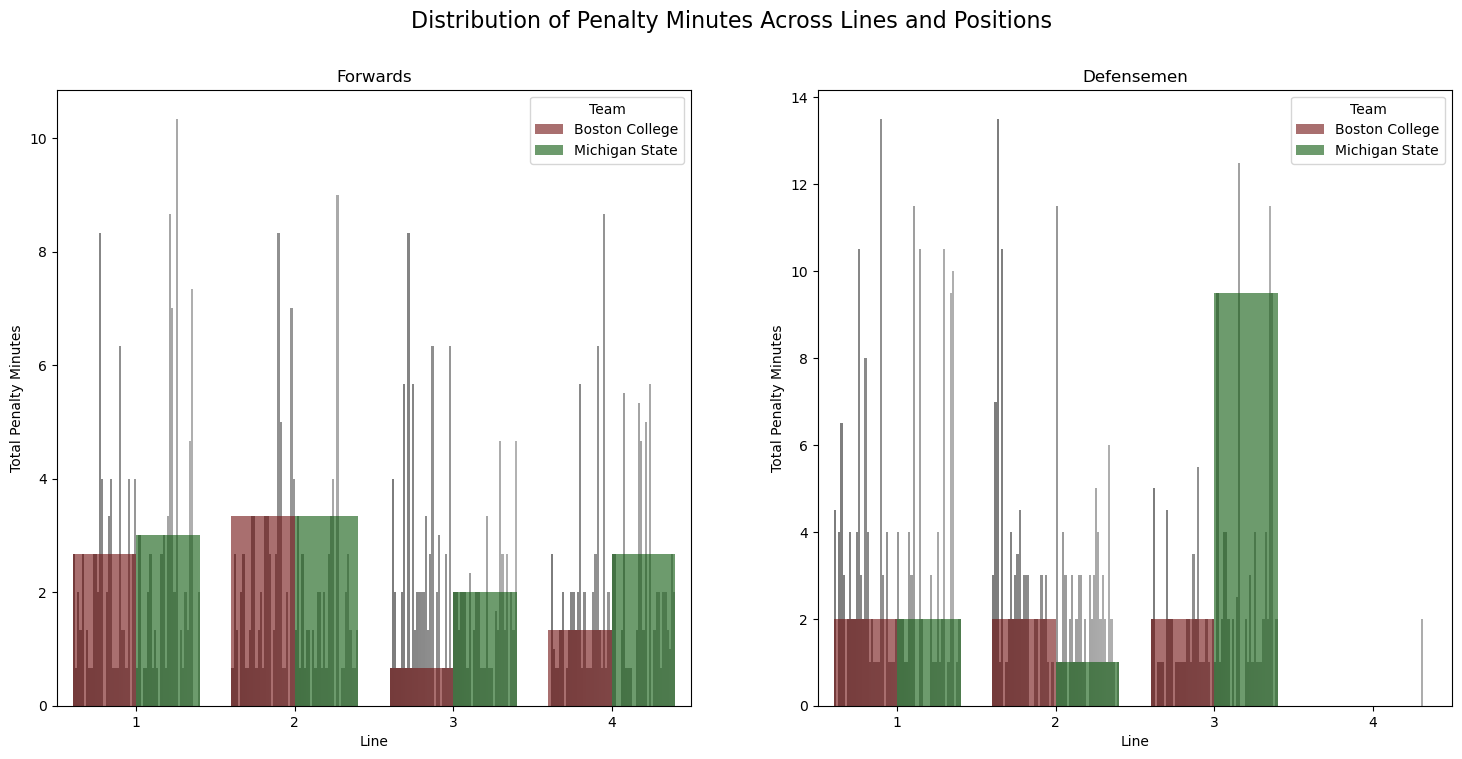

In [11]:
# Set up the plot for Penalty Minutes
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Distribution of Penalty Minutes Across Lines and Positions', fontsize=16)

# Plot data for Forwards
sns.barplot(x='Line', y='Total_PIM', hue='Team', data=forwards_data, 
            color='grey', alpha=0.6, ax=ax[0], ci=None)
sns.barplot(x='Line', y='Total_PIM', hue='Team', data=forwards_data[forwards_data['Team'].isin(['Michigan State', 'Boston College'])], 
            palette={'Michigan State': 'darkgreen', 'Boston College': 'maroon'}, ax=ax[0], ci=None, alpha=0.6)

# Plot data for Defensemen
sns.barplot(x='Line', y='Total_PIM', hue='Team', data=defense_data, 
            color='grey', alpha=0.6, ax=ax[1], ci=None)
sns.barplot(x='Line', y='Total_PIM', hue='Team', data=defense_data[defense_data['Team'].isin(['Michigan State', 'Boston College'])], 
            palette={'Michigan State': 'darkgreen', 'Boston College': 'maroon'}, ax=ax[1], ci=None, alpha=0.6)

# Add labels and title
ax[0].set_title('Forwards')
ax[1].set_title('Defensemen')
ax[0].set_xlabel('Line')
ax[1].set_xlabel('Line')
ax[0].set_ylabel('Total Penalty Minutes')
ax[1].set_ylabel('Total Penalty Minutes')

# Simplify the legend to only show Michigan State and Boston College
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[-2:], labels[-2:], title='Team')

handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[-2:], labels[-2:], title='Team')

# Show the plot
plt.show()


### Don't really like the below chart

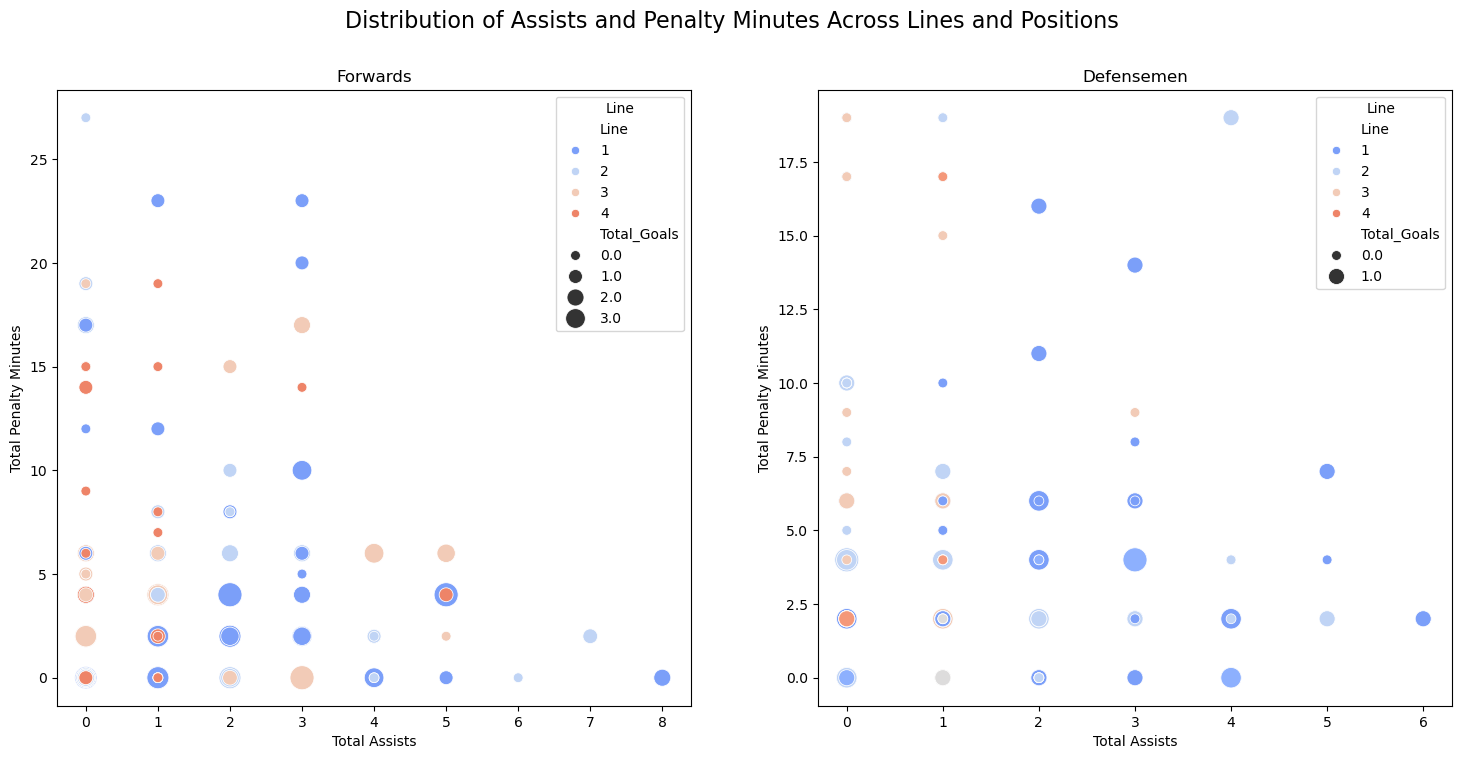

In [12]:
# # Set up the plot
# fig, ax = plt.subplots(1, 2, figsize=(18, 8))
# fig.suptitle('Distribution of Assists and Penalty Minutes Across Lines and Positions', fontsize=16)

# # Create a colormap for assists and penalty minutes
# cmap = sns.color_palette("coolwarm", as_cmap=True)

# # Plot data for Forwards
# sns.scatterplot(x='Total_Assists', y='Total_PIM', hue='Line', size='Total_Goals', 
#                 data=forwards_data, ax=ax[0], palette="coolwarm", sizes=(50, 300))
# sns.scatterplot(x='Total_Assists', y='Total_PIM', hue='Line', size='Total_Goals', 
#                 data=forwards_data[forwards_data['Team'].isin(['Michigan State', 'Boston College'])], 
#                 ax=ax[0], palette="coolwarm", sizes=(50, 300), legend=None)

# # Plot data for Defensemen
# sns.scatterplot(x='Total_Assists', y='Total_PIM', hue='Line', size='Total_Goals', 
#                 data=defense_data, ax=ax[1], palette="coolwarm", sizes=(50, 300))
# sns.scatterplot(x='Total_Assists', y='Total_PIM', hue='Line', size='Total_Goals', 
#                 data=defense_data[defense_data['Team'].isin(['Michigan State', 'Boston College'])], 
#                 ax=ax[1], palette="coolwarm", sizes=(50, 300), legend=None)

# # Add labels and title
# ax[0].set_title('Forwards')
# ax[1].set_title('Defensemen')
# ax[0].set_xlabel('Total Assists')
# ax[1].set_xlabel('Total Assists')
# ax[0].set_ylabel('Total Penalty Minutes')
# ax[1].set_ylabel('Total Penalty Minutes')

# # Simplify the legend to only show line categories
# handles, labels = ax[0].get_legend_handles_labels()
# ax[0].legend(handles[:-2], labels[:-2], title='Line')

# handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend(handles[:-2], labels[:-2], title='Line')

# # Show the plot
# plt.show()
